# Checkpoint 8: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones on `AEs`. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10AM Friday** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [3]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
# Keras import(s)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [5]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

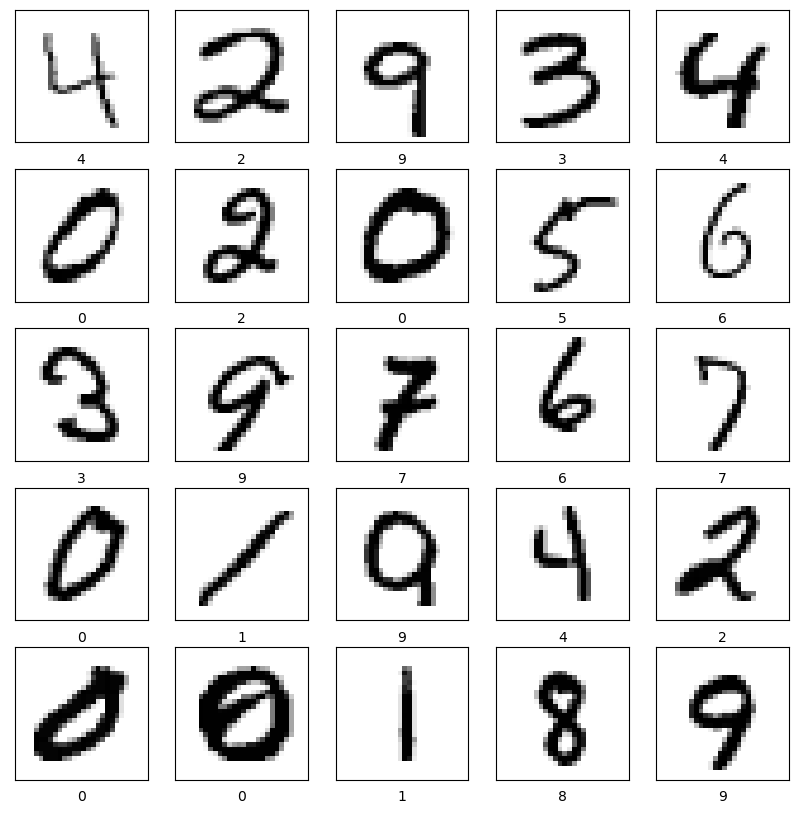

label marks [4 2 9 3 4 0 2 0 5 6 3 9 7 6 7 0 1 9 4 2 0 0 1 8 9]


In [6]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [7]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [8]:
intermediate_dim =256
latent_dim = 2

# NOTE: when constructing the encoder I started with several convolution layers in 16 8 4 2 1 but it would make the trainning too time consuming so I got rid of all of them


# constructing the encoder
input_imag = Input(shape=(28,28,1))
enc_flat = Flatten()(input_imag)
hidden  = Dense(intermediate_dim, activation = "relu" )(enc_flat)
hidden2 = Dense(intermediate_dim, activation = "relu")(hidden)
z_mean = Dense(latent_dim, name="z_mean")(hidden2)
z_log_var = Dense(latent_dim, name="z_log_var")(hidden2)
z = Lambda(sampling, output_shape=(latent_dim, ), name = "z")([z_mean, z_log_var])

encoder = Model(input_imag,[z_mean, z_log_var, z], name = "encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
____________________________________________________________________________________________

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [9]:
# constructing the decoder

input_dec = Input(shape=(2))
hidden  = Dense(256, activation = "relu" )(input_dec)
hidden2  = Dense(256, activation = "relu" )(hidden)
hidden3 = Dense(np.prod(shape), activation = "sigmoid")(hidden2)
shaped = Reshape(shape)(hidden3)

decoder = Model(input_dec, shaped, name = "decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

In [10]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [11]:
# building the VAE model

vae  = Model(i, o, name = "VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 267780    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         268048    
Total params: 535,828
Trainable params: 535,828
Non-trainable params: 0
_________________________________________________________________


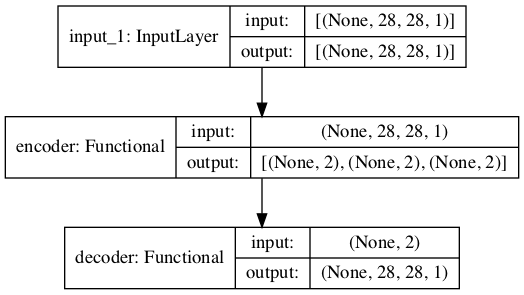

In [12]:
plot_model(vae, show_shapes = "True")

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [13]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Compile the model.
* Train for ca. **50 epochs**.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [14]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

In [15]:
# compiling the VAE

compile_vae(vae)
history_vae = vae.fit(X_train, X_train, epochs= nb_epochs, batch_size=batch_size, validation_split = 0.2) 
 

Train on 48000 samples, validate on 12000 samples


2023-01-19 11:57:25.484537: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 11:57:25.715990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Epoch 1/50
47744/48000 [============================>.] - ETA: 0s - loss: 198.4595 - reco_loss: 193.6161 - kl_loss: 4.8434

/Users/martadetoro/.conda/envs/daml/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 11s 233us/sample - loss: 198.3470 - reco_loss: 193.5057 - kl_loss: 4.8414 - val_loss: 173.1124 - val_reco_loss: 168.6736 - val_kl_loss: 4.4388
Epoch 2/50
48000/48000 [==============================] - 9s 178us/sample - loss: 169.2046 - reco_loss: 164.5299 - kl_loss: 4.6747 - val_loss: 165.9731 - val_reco_loss: 161.0331 - val_kl_loss: 4.9400
Epoch 3/50
48000/48000 [==============================] - 8s 174us/sample - loss: 163.8810 - reco_loss: 158.8865 - kl_loss: 4.9945 - val_loss: 160.9611 - val_reco_loss: 155.8075 - val_kl_loss: 5.1536
Epoch 4/50
48000/48000 [==============================] - 7s 150us/sample - loss: 159.3575 - reco_loss: 154.0128 - kl_loss: 5.3447 - val_loss: 157.2641 - val_reco_loss: 151.9039 - val_kl_loss: 5.3602
Epoch 5/50
48000/48000 [==============================] - 6s 134us/sample - loss: 156.3357 - reco_loss: 150.7873 - kl_loss: 5.5484 - val_loss: 154.8939 - val_reco_loss: 149.2909 - val_kl_loss: 5.6030
Epoch 6/50

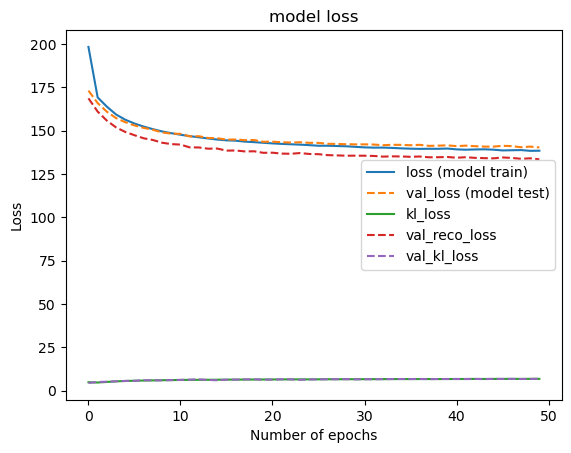

In [16]:
# plot losses to check that autoencoder is trainning correctly
plt.plot(history_vae.history['loss'])
plt.plot(history_vae.history['val_loss'],linestyle='dashed')
plt.plot(history_vae.history['kl_loss'])
plt.plot(history_vae.history['val_reco_loss'],linestyle='dashed')
plt.plot(history_vae.history['val_kl_loss'],linestyle='dashed')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['loss (model train)', 'val_loss (model test)', "kl_loss", "val_reco_loss", "val_kl_loss" ])
plt.show()

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

In [17]:
# predict the encoded images (laten space)

encoded_imags = encoder.predict(X_test)


In [18]:
# checking that the shape is as expected (latent space)
print(encoded_imags[2][0].shape)

(2,)


/var/folders/dk/1rs_mff912x4vkcx3d1b3nxr0000gn/T/ipykernel_24723/2003576151.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


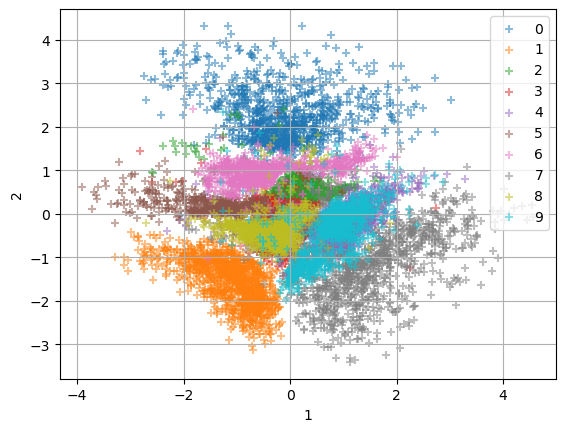

In [56]:
# digits inside a list 
digits = [0,1,2,3,4,5,6,7,8,9]

# creating scatter plot
fig, ax = plt.subplots()

for t in digits:

    mask = y_test == t

    ax.scatter(encoded_imags[2][mask,1], encoded_imags[2][mask,0], alpha = 0.5, label = t, marker = "+")

ax.legend()
# the axis are arbitrary 
ax.set_xlabel("1")
ax.set_ylabel("2")
ax.grid()
fig.show()

The digist that overlap are the ones that are confussed more easily, for example differentiate between a 3 and an 8 seems to be tricky, which looking at both shapes makes sense. The ones further more to the sides are not confussed with other digits that easily, 1, 0, and 2 seem to be easier to distinguish then. We cannot even see 4 (violet) that well, which means that it is really difficut to distinguish and often mistaken by 9 for example. 

#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

In [72]:
N = 10

# equally spaced grid
grid = np.linspace(-2, 2, N)
# mesh grid
grid2dx, grid2dy = np.meshgrid(grid, grid)

# creating an empty array 
my_array = np.empty([N**2, 2])

# fill the empty array with pairs of latent space coordinates (mesh grid)
b = 0 
for i in range(N):
    for j in range(N):
        my_array[b][0] = grid2dx[i][j]
        my_array[b][1] = grid2dy[i][j]

        b += 1

        


In [73]:
print(my_array)

[[-2.         -2.        ]
 [-1.55555556 -2.        ]
 [-1.11111111 -2.        ]
 [-0.66666667 -2.        ]
 [-0.22222222 -2.        ]
 [ 0.22222222 -2.        ]
 [ 0.66666667 -2.        ]
 [ 1.11111111 -2.        ]
 [ 1.55555556 -2.        ]
 [ 2.         -2.        ]
 [-2.         -1.55555556]
 [-1.55555556 -1.55555556]
 [-1.11111111 -1.55555556]
 [-0.66666667 -1.55555556]
 [-0.22222222 -1.55555556]
 [ 0.22222222 -1.55555556]
 [ 0.66666667 -1.55555556]
 [ 1.11111111 -1.55555556]
 [ 1.55555556 -1.55555556]
 [ 2.         -1.55555556]
 [-2.         -1.11111111]
 [-1.55555556 -1.11111111]
 [-1.11111111 -1.11111111]
 [-0.66666667 -1.11111111]
 [-0.22222222 -1.11111111]
 [ 0.22222222 -1.11111111]
 [ 0.66666667 -1.11111111]
 [ 1.11111111 -1.11111111]
 [ 1.55555556 -1.11111111]
 [ 2.         -1.11111111]
 [-2.         -0.66666667]
 [-1.55555556 -0.66666667]
 [-1.11111111 -0.66666667]
 [-0.66666667 -0.66666667]
 [-0.22222222 -0.66666667]
 [ 0.22222222 -0.66666667]
 [ 0.66666667 -0.66666667]
 

In [74]:
# predict the decoded images (generated images)
decod_imags = decoder.predict(my_array)

In [75]:
# cehck that the shape is as expected (initial shape of images)
print(decod_imags[0].shape)

(28, 28, 1)


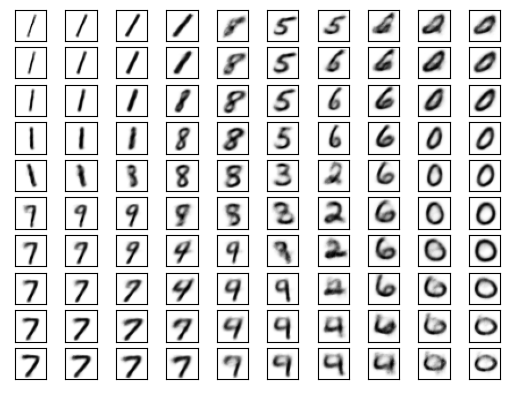

In [76]:
# display decoded images

n = 10  # How many digits we will display

fig, ax = plt.subplots(n, n)

k = 0 
for i in range(n):

    for j in range(n):

    
        ax[i][j].imshow(decod_imags[k], cmap = plt.cm.binary)   
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)

        k += 1
 
plt.show()

The results for the generated images are in agreement with the generated scatter plot above. Because of the way I created the grid, the top lef corner of the generated images correspond to the -2,-2 section of the scattered plot, ie the section full of 1, which make sense. We can also see that the number 1 generated is easy to distinguih from other digits wich is also in agreement with the scatter plot. Then we can move to the corner with lots of 7s, which would correspond to the grid space of 2,-2 on the scatter plot, there we can see the 7s easily but we can also see how there's a bit of confussion with some 9s (fact that it's also reflected in the plot). The section where 0s turn into 6s is also reflected in both, the scatter plot and the generated images. In coclusion both things are in agreement and the generated images explain and show why the scatter plot makes sense.

# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [24]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?

`--------------------------------------------------------------------------------------------------------------------------------------------------------`
*Questions answered with the use of the lecture slides, the given resource, and keras.io webpage*

`--------------------------------------------------------------------------------------------------------------------------------------------------------`
Purpose of the discriminator in a GAN: the discriminator distinguish between fake data and true data produced by the model Generator (this is done by returning a probability that determines if the data is fake or real).

The Discriminator networs is a standard convolutional network that categorizes the data being feed to it. It also performs downsampling and classifies the images in a binary way, labelling finally each data as fake or real. In the given dicriminator below we can see two convolution layers, and a Dense one with sigmoid activation (good for binary classification probability). The LeakyReLU layer allows a small gradient when the unit is not active, it performs a threshold operation, where any input value less than zero is multiplied by a fixed scalar. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training, which allows preventing overfitting.

Binary crossentropy is used as a loss function as it measures the difference between the distribution of predicitions made by the discriminator and the true distribution of the data that it sees (this is appropiate for inary classification).

In [25]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0

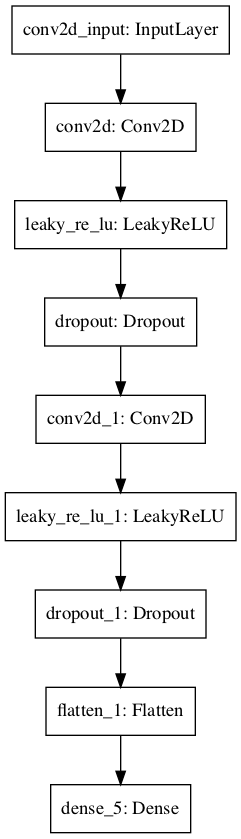

In [26]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?

`--------------------------------------------------------------------------------------------------------------------------------------------------------`
The Generator uses "random noise" (random number distribution) as an input to generate fake data (in this case fake images).

The Conv2DTranspose layer is used for two things; it performs a convolution operation whose kernel is learnt (so like a normal Conv2D operation) while trainning the model. And, it also unsample its output (this is different to a normal upsampling layer as the model also learns what is the best upsampling for the case).

Sigmoid is used as the activation function because it gives a value between the range of 0 to 1 (which is the desired range)

In [27]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

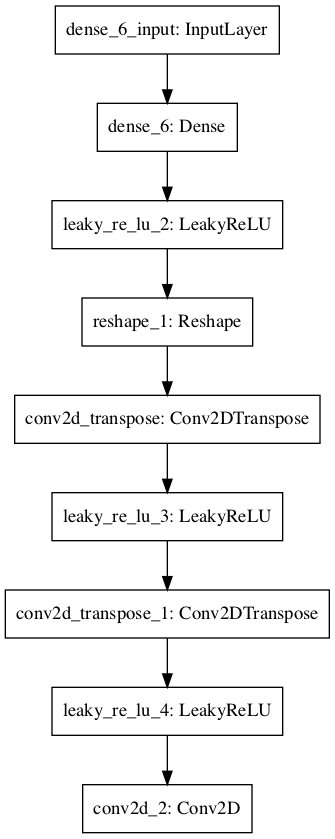

In [28]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.

`--------------------------------------------------------------------------------------------------------------------------------------------------------`
The Generator receives an input of random points in the latent space and with that it generates samples (or fake data) that is then given to the discriminator (that would be the input of the DIscriminator + real data as input for the discriminator as well). The Discriminator then classifies the data (images in this case) as fake or real.

The Discriminator is set as non-trainable because at this stage the Generator is training and if we do not keep the Discirminator constant the Generator might never converge. In other words, we want to train the Generator to trick the Discriminator so we want to stop the trainning of the Discriminator when the Generator is trainning.

In [29]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


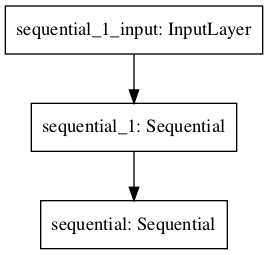

In [30]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?

`--------------------------------------------------------------------------------------------------------------------------------------------------------`

The data generated in the generate_real_samples is used to train the discriminator in batches, (def generate_real_samples divides the preapred data into smaller sets for the trainning).
With the y = ones((n_samples,1)) we mark the data in this small sets as "True" to diferentiatiate from the data created later by the Generator (fake data), so this is used for the trainning.

In [31]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

`--------------------------------------------------------------------------------------------------------------------------------------------------------`
The image looks (in terms of shape and format) to the real images, but there is not an actual digit (number) in the image, but it kind of looks like there could be one.

In [32]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

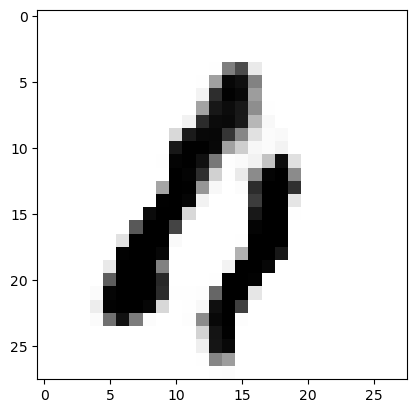

In [87]:
plt.imshow(generate_fake_samples(g_model,latent_dim,1)[0].reshape((28,28,1)),cmap=plt.cm.binary)

---
Some functions for saving GAN models and output images

In [33]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 

`--------------------------------------------------------------------------------------------------------------------------------------------------------`

The i loop The j loop is important in order to enumerate the batches over the trainning set per epoch. 
inside the loop, the first thing we do is generate subsets of real images using the (already discussed above) generate_real_samples function, then we generate subsets of fake images using the function generate_fake_samples. The we put together the generated real and fake samples to cerate the set of images that we are going to use to train the discriminator. Hence in the line d_loss, _ = d_model.train_on_batch(X, y) we train and update the discriminator (that batch). The next line, with the generate_latent_points we generate latent points to feed to the generator ("random noise"). Then we update the generator by trainning it.
Lastly, we print the losses on the batch in order to monitor them.

In [34]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have a GPU or some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

`--------------------------------------------------------------------------------------------------------------------------------------------------------`
The loss functions evolve as expected, i.e. when the generator losses go up, the discriminator losses go down, and viceversa. Also, when comparing it to the resource given ([here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/)), the resource says that we should expect the discriminator losses move around 0.5-0.8 (for this case of the MNIST data set). The resource also says that the Generator losses are less critical and that they might fluctuate between 0.5-2.0 or higher.

In [83]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=5)

>1, 1/234, d=0.673, g=0.724
>1, 2/234, d=0.673, g=0.729
>1, 3/234, d=0.671, g=0.770
>1, 4/234, d=0.661, g=0.759
>1, 5/234, d=0.664, g=0.766
>1, 6/234, d=0.646, g=0.767
>1, 7/234, d=0.669, g=0.784
>1, 8/234, d=0.655, g=0.755
>1, 9/234, d=0.662, g=0.761
>1, 10/234, d=0.650, g=0.765
>1, 11/234, d=0.647, g=0.746
>1, 12/234, d=0.649, g=0.753
>1, 13/234, d=0.678, g=0.738
>1, 14/234, d=0.659, g=0.730
>1, 15/234, d=0.686, g=0.735
>1, 16/234, d=0.686, g=0.717
>1, 17/234, d=0.690, g=0.721
>1, 18/234, d=0.669, g=0.714
>1, 19/234, d=0.688, g=0.708
>1, 20/234, d=0.688, g=0.695
>1, 21/234, d=0.677, g=0.703
>1, 22/234, d=0.703, g=0.713
>1, 23/234, d=0.670, g=0.714
>1, 24/234, d=0.692, g=0.705
>1, 25/234, d=0.696, g=0.707
>1, 26/234, d=0.689, g=0.717
>1, 27/234, d=0.680, g=0.718
>1, 28/234, d=0.680, g=0.719
>1, 29/234, d=0.698, g=0.726
>1, 30/234, d=0.673, g=0.726
>1, 31/234, d=0.673, g=0.737
>1, 32/234, d=0.672, g=0.732
>1, 33/234, d=0.659, g=0.744
>1, 34/234, d=0.682, g=0.742
>1, 35/234, d=0.668, g=

/Users/martadetoro/.conda/envs/daml/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


>Accuracy real: 45%, fake: 89%
>3, 1/234, d=0.659, g=0.744
>3, 2/234, d=0.670, g=0.756
>3, 3/234, d=0.658, g=0.745
>3, 4/234, d=0.656, g=0.753
>3, 5/234, d=0.665, g=0.765
>3, 6/234, d=0.663, g=0.759
>3, 7/234, d=0.664, g=0.765
>3, 8/234, d=0.662, g=0.770
>3, 9/234, d=0.662, g=0.782
>3, 10/234, d=0.662, g=0.773
>3, 11/234, d=0.658, g=0.777
>3, 12/234, d=0.663, g=0.770
>3, 13/234, d=0.668, g=0.755
>3, 14/234, d=0.661, g=0.745
>3, 15/234, d=0.670, g=0.742
>3, 16/234, d=0.676, g=0.738
>3, 17/234, d=0.674, g=0.741
>3, 18/234, d=0.675, g=0.724
>3, 19/234, d=0.676, g=0.709
>3, 20/234, d=0.679, g=0.727
>3, 21/234, d=0.691, g=0.717
>3, 22/234, d=0.686, g=0.709
>3, 23/234, d=0.687, g=0.718
>3, 24/234, d=0.675, g=0.713
>3, 25/234, d=0.679, g=0.704
>3, 26/234, d=0.688, g=0.713
>3, 27/234, d=0.696, g=0.709
>3, 28/234, d=0.696, g=0.716
>3, 29/234, d=0.703, g=0.712
>3, 30/234, d=0.694, g=0.711
>3, 31/234, d=0.697, g=0.717
>3, 32/234, d=0.693, g=0.721
>3, 33/234, d=0.693, g=0.723
>3, 34/234, d=0.703, 

In [84]:
# random array to feed into the generator
array = np.random.rand(25,100)

# obtaining generated images
generated = g_model.predict(array)

In [85]:
print(np.shape(generated))

(25, 28, 28, 1)


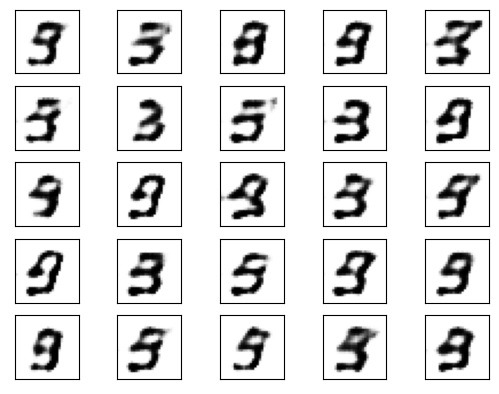

In [86]:
# display generated images

n = 5  

fig, ax = plt.subplots(n, n)

k = 0 
for i in range(n):

    for j in range(n):

    
        ax[i][j].imshow(generated[k], cmap = plt.cm.binary)   
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)

        k += 1
 
plt.show()

NOTE: I first did it for 1 epoch and the images were very blurry and difficult to distinguish any number, with 5 epochs I can see something like a 9, a 5 and a 3.

**END OF NOTEBOOK**